In [14]:
from quake.utils.utils import load_runcard, save_runcard
from quake.models.autoencoder.autoencoder_dataloading import read_data
from quake.models.autoencoder.train import load_and_compile_network
import numpy as np
from pathlib import Path
from quake.models.qsvm.qsvm_tester import get_features
from qiskit.circuit.library import ZZFeatureMap
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from quake.models.qsvm import genetic_v3 as genetic
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import pandas as pd
from qiskit import Aer
from collections import OrderedDict


import time

In [15]:
# Dataset loading
data_folder = Path("../../output_2/data")
train_folder = Path("../../output_2/models/autoencoder")
setup = load_runcard("../../output_2/cards/runcard.yaml")
setup["run_tf_eagerly"] = True
setup["seed"] = 42
dataset, labels = get_features(data_folder.parent, "autoencoder", setup)
scaler = MinMaxScaler((0,1)).fit(dataset[0])
data_cv, data_labels = genetic.get_subsample(dataset[2], labels[2], 50, scaler = scaler)
nb_features = data_cv.shape[1]

[INFO] (quake.autoencoder) Loading splitting maps from folder: ..\..\output_2\models\autoencoder
INFO:quake.autoencoder:Loading splitting maps from folder: ..\..\output_2\models\autoencoder
[INFO] (quake.autoencoder) Train dataset balancing: 125517 training points, of which 50.12% positives
INFO:quake.autoencoder:Train dataset balancing: 125517 training points, of which 50.12% positives
[INFO] (quake.autoencoder) Validation dataset balancing: 26897 training points, of which 49.77% positives
INFO:quake.autoencoder:Validation dataset balancing: 26897 training points, of which 49.77% positives
[INFO] (quake.autoencoder) Test dataset balancing: 26897 training points, of which 49.74% positives
INFO:quake.autoencoder:Test dataset balancing: 26897 training points, of which 49.74% positives
[INFO] (quake.autoencoder) Loading weights at ..\..\output_2\models\autoencoder\autoencoder.h5
INFO:quake.autoencoder:Loading weights at ..\..\output_2\models\autoencoder\autoencoder.h5


897/897 [==============================] - 5s 5ms/step


In [16]:
suffix = '2023_12_16 -13_57_02'
df = pd.read_csv("../../Output_genetic/"+suffix+"/genes"+suffix+".csv", header = None, index_col=False)
accuracies = np.loadtxt("../../Output_genetic/"+suffix+"/accuracy"+suffix+".txt")
sparsities = np.loadtxt("../../Output_genetic/"+suffix+"/sparsity"+suffix+".txt")
fitnesses = np.loadtxt("../../Output_genetic/"+suffix+"/fitness_values_iter_"+suffix+".txt")
# best_fitness = np.loadtxt("../../Output_genetic/"+suffix+"/best_fitness_per_generation"+suffix+".txt", delimiter = ",")
# runtime: 33502s
n_epochs = 31
keep_elitism = 4
pop_size = 50

fittest_kernel_id = np.argmax(fitnesses)

genes = df.to_numpy()
NB_QUBITS = 6
GATES_PER_QUBITS = 6
gate_dict = OrderedDict([
    ("single_non_parametric", ["I", "H", "X"]),
    ("single_parametric", ["RX", "RY", "RZ"]),
    ("two_non_parametric", ["CX"]),
    ("two_parametric", ["CRX", "CRY", "CRZ"]),
])
nb_features = 18
fmap, x_idxs = genetic.to_quantum(genes[fittest_kernel_id], gate_dict, nb_features, GATES_PER_QUBITS, NB_QUBITS)
print(np.sort(x_idxs))

[ 0  1  2  3  5  6  7  8  9 10 11 13 15 16 17]


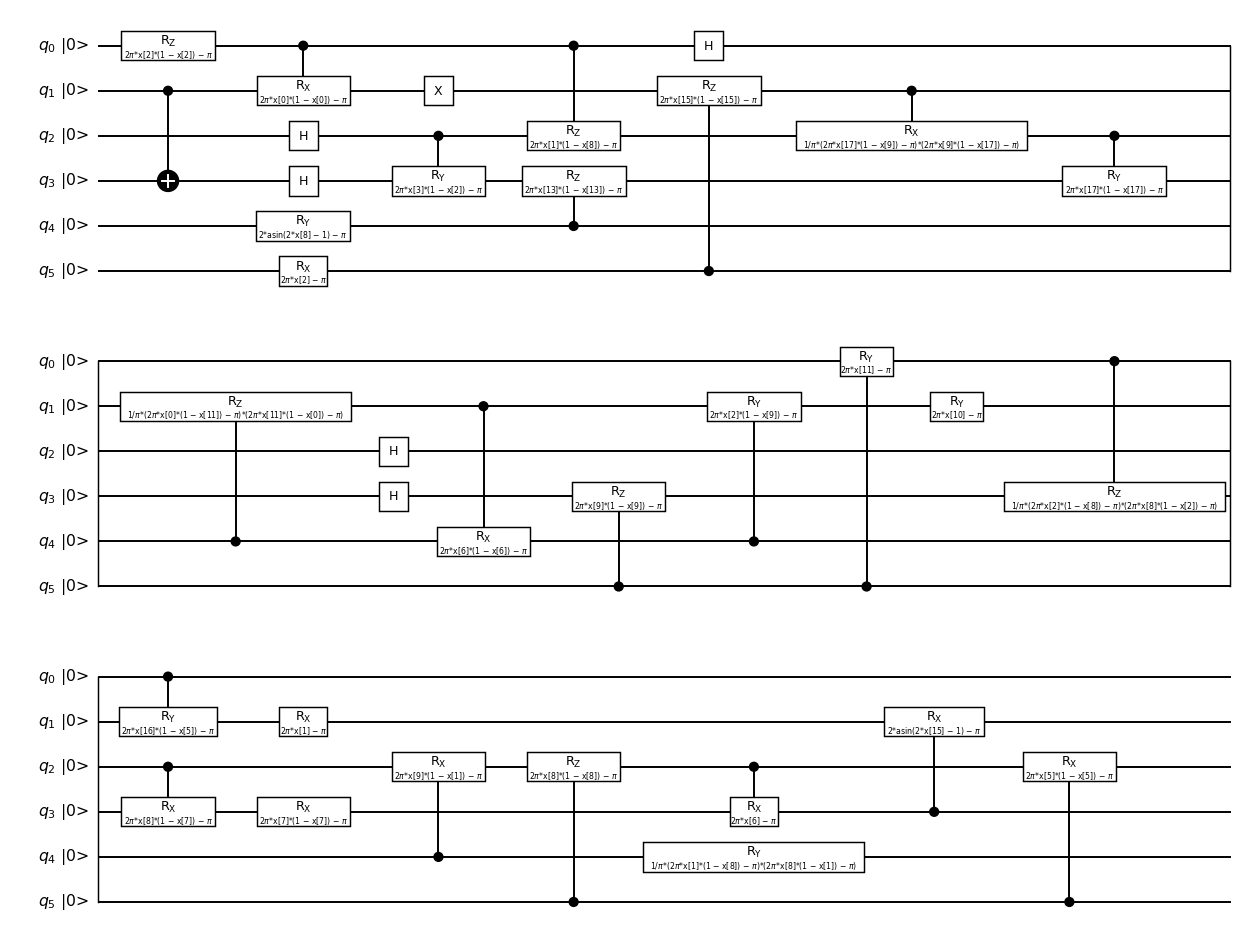

In [17]:
fmap.draw(output='mpl', scale=0.7, initial_state=True, cregbundle=False, style="bw")

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
clf = SVC(kernel="precomputed")

param_grid = {"C": [0.01, 0.1, 1, 10, 100, 1000, 10000]}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy")

# qkernel = genetic.projected_quantum_kernel(fmap, data_cv[:, x_idxs], 1)

In [19]:
qkernel_variant = genetic.projected_quantum_kernel_variant(fmap, data_cv[:, x_idxs], 1)

C:\Users\RobertoMoretti\Documents\Genetic Work\QuaKe\src\quake\models\qsvm\genetic_v3.py:635: FutureWarning: The input object of type 'DensityMatrix' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'DensityMatrix', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  statevector_dm = np.array([DensityMatrix(fmap.assign_parameters(data)) for data in dataset])
C:\Users\RobertoMoretti\Documents\Genetic Work\QuaKe\src\quake\models\qsvm\genetic_v3.py:635: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creat

In [26]:
qkernel_variant

array([[2.        , 0.34060059, 0.17097234, ..., 0.12028467, 0.28786247,
        0.13582089],
       [0.34060059, 2.        , 0.34223722, ..., 0.1854056 , 0.33282312,
        0.16719677],
       [0.17097234, 0.34223722, 2.        , ..., 0.13879372, 0.17747259,
        0.09115466],
       ...,
       [0.12028467, 0.1854056 , 0.13879372, ..., 2.        , 0.19269851,
        0.09463704],
       [0.28786247, 0.33282312, 0.17747259, ..., 0.19269851, 2.        ,
        0.17258481],
       [0.13582089, 0.16719677, 0.09115466, ..., 0.09463704, 0.17258481,
        2.        ]])

In [21]:
103/9

11.444444444444445

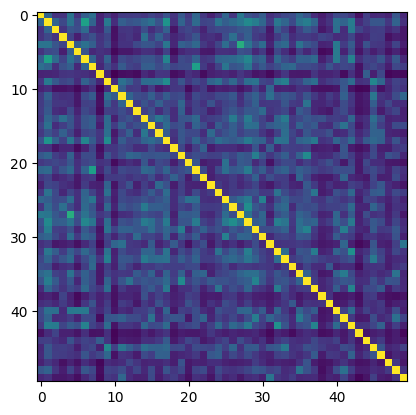

In [22]:
import matplotlib.pyplot as plt
plt.imshow(qkernel)

In [23]:
grid_search.fit(qkernel, data_labels)
best_clf = grid_search.best_estimator_
accuracy_cv = cross_val_score(
    best_clf, qkernel, data_labels, cv=5, scoring="accuracy"
)
fitness_value = np.mean(accuracy_cv)
print(fitness_value)

0.6199999999999999


In [24]:
qker_matrix_0 = qkernel[data_labels == 0]
qker_matrix_0 = np.triu(qker_matrix_0[:, data_labels == 0], 1)
qker_array_0 = qker_matrix_0[np.triu_indices(qker_matrix_0.shape[0], 1)]
qker_matrix_1 = qkernel[data_labels == 1]
qker_matrix_1 = np.triu(qker_matrix_1[:, data_labels == 1], 1)
qker_array_1 = qker_matrix_1[np.triu_indices(qker_matrix_1.shape[0], 1)]
qker_matrix_01 = qkernel[data_labels == 0]
qker_matrix_01 = qker_matrix_01[:,data_labels == 1]  
      
sparsity_cost = (np.mean(qker_array_0) + np.mean(qker_array_1))/2 - np.mean(qker_matrix_01)

In [25]:
sparsity_cost

0.0005034010078999174